## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## Load Data

In [2]:
df = pd.read_csv("../artifacts/raw/data.csv")

C:\Users\sumit\AppData\Local\Temp\ipykernel_8784\618008779.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../artifacts/raw/data.csv")


## Basic EDA

In [3]:
df.shape

(404800, 27)

In [4]:
df.head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     404800 non-null  object 
 1   gender                  404800 non-null  object 
 2   marital_status          404800 non-null  object 
 3   education               402396 non-null  object 
 4   monthly_salary          404800 non-null  object 
 5   employment_type         404800 non-null  object 
 6   years_of_employment     404800 non-null  float64
 7   company_type            404800 non-null  object 
 8   house_type              404800 non-null  object 
 9   monthly_rent            402374 non-null  float64
 10  family_size             404800 non-null  int64  
 11  dependents              404800 non-null  int64  
 12  school_fees             404800 non-null  float64
 13  college_fees            404800 non-null  float64
 14  travel_expenses     

## Fixing dtypes

In [6]:
categorical_cols = [
    "gender", "marital_status", "education", "employment_type", 
    "company_type", "house_type", "existing_loans", 
    "emi_scenario", "emi_eligibility"
]
numerical_cols = [
    "age", "monthly_salary", "years_of_employment", "monthly_rent", 
    "family_size", "dependents", "school_fees", "college_fees", 
    "travel_expenses", "groceries_utilities", "other_monthly_expenses", 
    "current_emi_amount", "credit_score", "bank_balance", 
    "emergency_fund", "requested_amount", "requested_tenure", 
    "max_monthly_emi"
]

In [7]:
for col in df.columns:
    if col in categorical_cols:
        df[col] = df[col].astype('category')
    elif col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   age                     404797 non-null  float64 
 1   gender                  404800 non-null  category
 2   marital_status          404800 non-null  category
 3   education               402396 non-null  category
 4   monthly_salary          402807 non-null  float64 
 5   employment_type         404800 non-null  category
 6   years_of_employment     404800 non-null  float64 
 7   company_type            404800 non-null  category
 8   house_type              404800 non-null  category
 9   monthly_rent            402374 non-null  float64 
 10  family_size             404800 non-null  int64   
 11  dependents              404800 non-null  int64   
 12  school_fees             404800 non-null  float64 
 13  college_fees            404800 non-null  float64 
 14  trav

In [9]:
df.isna().sum().sort_values(ascending = False)

bank_balance              4392
monthly_rent              2426
credit_score              2420
education                 2404
emergency_fund            2351
monthly_salary            1993
age                          3
years_of_employment          0
gender                       0
marital_status               0
employment_type              0
family_size                  0
house_type                   0
company_type                 0
dependents                   0
groceries_utilities          0
school_fees                  0
college_fees                 0
travel_expenses              0
current_emi_amount           0
existing_loans               0
other_monthly_expenses       0
emi_scenario                 0
requested_amount             0
requested_tenure             0
emi_eligibility              0
max_monthly_emi              0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,404797.0,38.875832,9.303572,26.0,32.0,38.0,48.0,59.0
monthly_salary,402807.0,59509.340498,43388.297878,3967.0,35400.0,51700.0,73000.0,499970.0
years_of_employment,404800.0,5.364079,6.079135,0.5,1.2,3.2,7.2,36.0
monthly_rent,402374.0,5828.446490,8648.604639,0.0,0.0,0.0,10600.0,80000.0
family_size,404800.0,2.940425,1.075199,1.0,2.0,3.0,4.0,5.0
dependents,404800.0,1.940425,1.075199,0.0,1.0,2.0,3.0,4.0
school_fees,404800.0,4624.575593,5061.074401,0.0,0.0,3000.0,9000.0,15000.0
college_fees,404800.0,4066.253706,7319.344289,0.0,0.0,0.0,6500.0,25000.0
travel_expenses,404800.0,5687.497777,3392.671132,600.0,3200.0,4900.0,7400.0,30300.0
groceries_utilities,404800.0,12804.999506,6993.853745,1800.0,7700.0,11400.0,16400.0,71200.0


# CLASSIFICATION PROBLEM

## TARGET DISTRIBUTION

In [11]:
df["emi_eligibility"].value_counts(normalize=True)

emi_eligibility
Not_Eligible    0.772895
Eligible        0.183903
High_Risk       0.043202
Name: proportion, dtype: float64

## FEATURE TYPE IDENTIFICATION

In [12]:
categorical_cols = [
    "gender", "marital_status", "education",
    "employment_type", "company_type",
    "house_type", "existing_loans",
    "emi_scenario"
]

numerical_cols = [
    col for col in df.columns
    if col not in categorical_cols + ["emi_eligibility", "max_monthly_emi"]
]


## DOMAIN FEATURE ENGINEERING

In [13]:
EPS = 1e-6

df["total_monthly_expenses"] = (
    df["monthly_rent"] +
    df["school_fees"] +
    df["college_fees"] +
    df["travel_expenses"] +
    df["groceries_utilities"] +
    df["other_monthly_expenses"] +
    df["current_emi_amount"]
)

df["disposable_income"] = df["monthly_salary"] - df["total_monthly_expenses"]

df["emi_burden_ratio"] = df["current_emi_amount"] / (df["monthly_salary"] + EPS)

df["expense_income_ratio"] = df["total_monthly_expenses"] / (df["monthly_salary"] + EPS)

df["emergency_fund_ratio"] = df["emergency_fund"] / (df["total_monthly_expenses"] + EPS)

df["savings_ratio"] = df["bank_balance"] / (df["monthly_salary"] * 6 + EPS)


In [14]:
df["existing_loans"] = df["existing_loans"].map({"Yes": 1, "No": 0})

## TARGET & FEATURE SPLIT

In [15]:
X = df.drop(columns=["emi_eligibility", "max_monthly_emi"])
y = df["emi_eligibility"]


## TARGET ENCODING

In [16]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
label_mapping

{'Eligible': 0, 'High_Risk': 1, 'Not_Eligible': 2}

## HANDLE CLASS IMBALANCE

In [17]:
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(zip(np.unique(y_encoded), class_weights_arr))
class_weights

{np.int64(0): np.float64(1.812548134615729),
 np.int64(1): np.float64(7.715767002134797),
 np.int64(2): np.float64(0.4312787927603121)}

## TRAIN–TEST SPLIT (STRATIFIED)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

## REPROCESSING PIPELINE

In [19]:
categorical_features = [
    "gender", "marital_status", "education",
    "employment_type", "company_type",
    "house_type", "emi_scenario"
]

numerical_features = [
    col for col in X.columns if col not in categorical_features
]


In [20]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


In [21]:
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

## APPLY PREPROCESSING

In [22]:
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

np.isnan(X_train_p).sum()  # must be 0

np.int64(0)

## MODEL 1 — LOGISTIC REGRESSION (BASELINE)

In [23]:
log_reg = LogisticRegression(
    class_weight=class_weights,
    max_iter=2000,
    n_jobs=-1
)

log_reg.fit(X_train_p, y_train)

y_pred_lr = log_reg.predict(X_test_p)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

Logistic Regression
              precision    recall  f1-score   support

    Eligible       0.82      0.73      0.78     14889
   High_Risk       0.14      0.65      0.23      3497
Not_Eligible       0.98      0.80      0.89     62574

    accuracy                           0.79     80960
   macro avg       0.65      0.73      0.63     80960
weighted avg       0.92      0.79      0.84     80960



## MODEL 2 — RANDOM FOREST

In [24]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train)

y_pred_rf = rf.predict(X_test_p)

print("Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest
              precision    recall  f1-score   support

    Eligible       0.85      0.80      0.83     14889
   High_Risk       0.18      0.66      0.28      3497
Not_Eligible       0.99      0.85      0.92     62574

    accuracy                           0.83     80960
   macro avg       0.67      0.77      0.67     80960
weighted avg       0.93      0.83      0.87     80960



## MODEL 3 — LIGHTGBM

In [25]:
lgb_sample_weights = np.array([class_weights[c] for c in y_train])

In [26]:
lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y_train)),
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [27]:
lgbm.fit(
    X_train_p,
    y_train,
    sample_weight=lgb_sample_weights
)

y_pred_lgb = lgbm.predict(X_test_p)

print("LightGBM")
print(classification_report(y_test, y_pred_lgb, target_names=label_encoder.classes_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4843
[LightGBM] [Info] Number of data points in the train set: 323840, number of used features: 54
[LightGBM] [Info] Start training from score -1.098628
[LightGBM] [Info] Start training from score -1.098582
[LightGBM] [Info] Start training from score -1.098627


c:\Users\sumit\OneDrive\Desktop\EMIPredict AI - Intelligent Financial Risk Assessment Platform\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM
              precision    recall  f1-score   support

    Eligible       0.99      0.89      0.93     14889
   High_Risk       0.37      0.96      0.53      3497
Not_Eligible       1.00      0.93      0.96     62574

    accuracy                           0.92     80960
   macro avg       0.78      0.93      0.81     80960
weighted avg       0.97      0.92      0.94     80960



# REGRESSION PROBLEM

In [28]:
X_reg = df.drop(columns=["emi_eligibility", "max_monthly_emi"])
y_reg = df["max_monthly_emi"]

### TRAIN–TEST SPLIT

In [29]:
from sklearn.model_selection import train_test_split

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

### DEFINE FEATURE GROUPS

In [30]:
categorical_features = [
    "gender",
    "marital_status",
    "education",
    "employment_type",
    "company_type",
    "house_type",
    "emi_scenario"
]

numerical_features = list(
    set(X_reg.columns) - set(categorical_features)
)


### REPROCESSING PIPELINE

In [32]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [33]:
preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features)
    ]
)


### TRANSFORM DATA

In [34]:
Xr_train_p = preprocessor_reg.fit_transform(Xr_train)
Xr_test_p = preprocessor_reg.transform(Xr_test)

import numpy as np
np.isnan(Xr_train_p).sum()  # must be 0

np.int64(0)

## REGRESSION MODELS

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

In [36]:
lr_reg = LinearRegression()
lr_reg.fit(Xr_train_p, yr_train)

yr_pred_lr = lr_reg.predict(Xr_test_p)

In [40]:
print("Linear Regression")
print("RMSE:", root_mean_squared_error(yr_test, yr_pred_lr))
print("MAE :", mean_absolute_error(yr_test, yr_pred_lr))
print("R²  :", r2_score(yr_test, yr_pred_lr))

Linear Regression
RMSE: 4058.813145871538
MAE : 2901.986474794656
R²  : 0.7209526100634787


## MODEL 2: RANDOM FOREST REGRESSOR

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(Xr_train_p, yr_train)

yr_pred_rf = rf_reg.predict(Xr_test_p)

In [44]:
print("Random Forest Regressor")
print("RMSE:", root_mean_squared_error(yr_test, yr_pred_rf))
print("MAE :", mean_absolute_error(yr_test, yr_pred_rf))
print("R²  :", r2_score(yr_test, yr_pred_rf))

Random Forest Regressor
RMSE: 958.2829008855076
MAE : 315.12673922495026
R²  : 0.984445096332289


## MODEL 3: LIGHTGBM REGRESSOR

In [45]:
lgb_reg = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


In [46]:
lgb_reg.fit(Xr_train_p, yr_train)

yr_pred_lgb = lgb_reg.predict(Xr_test_p)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4844
[LightGBM] [Info] Number of data points in the train set: 323840, number of used features: 54
[LightGBM] [Info] Start training from score 6770.019742


c:\Users\sumit\OneDrive\Desktop\EMIPredict AI - Intelligent Financial Risk Assessment Platform\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [47]:
print("LightGBM Regressor")
print("RMSE:", root_mean_squared_error(yr_test, yr_pred_lgb))
print("MAE :", mean_absolute_error(yr_test, yr_pred_lgb))
print("R²  :", r2_score(yr_test, yr_pred_lgb))

LightGBM Regressor
RMSE: 645.8954300971725
MAE : 234.6817705218936
R²  : 0.9929335014910862


## REGRESSION DIAGNOSTIC PLOT

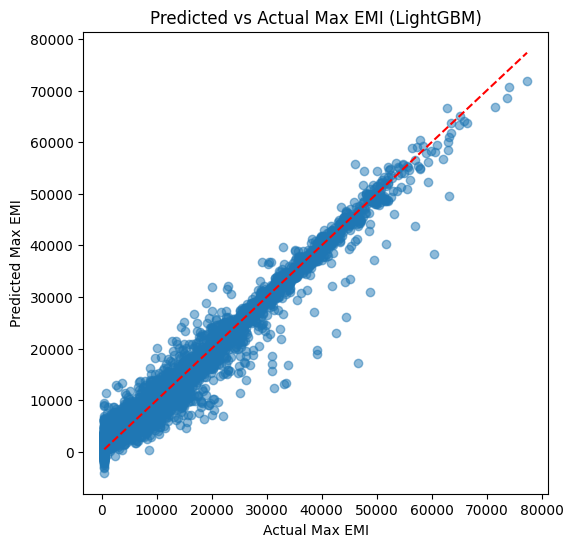

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(yr_test, yr_pred_lgb, alpha=0.5)
plt.plot([yr_test.min(), yr_test.max()],
         [yr_test.min(), yr_test.max()],
         "r--")
plt.xlabel("Actual Max EMI")
plt.ylabel("Predicted Max EMI")
plt.title("Predicted vs Actual Max EMI (LightGBM)")
plt.show()